# Preprocessing Data
## Import Dependencies

In [10]:
import numpy as np
import os
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/yao/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Import test sample 

In [5]:
with open('../../data/Wireless_network.txt') as f:
    lines = f.readlines()
    f.close()

# Tokenization and Cleaning
Below we tokenize the articles using some of the nltk libraries.

In [ ]:
stop_words = set(stopwords.words('english'))

def split_data(lines): 
    """splits the summary from the body and names the body lines"""
    for i in range(len(lines)):
        if lines[i][0] == '\n':
            summary = lines[:i]
            lines = lines[i:]
            return summary, lines

def split_string(lines):
    sent_tokens = []
    for line in lines:
        line = re.sub("\n", "", line)
        line = re.sub("\\\\.", "", line)
        line = re.sub("===", "", line)
        for sent in sent_tokenize(line):
            sent_tokens.append(sent)
    return sent_tokens

def split_summary(lines):
    sent_tokens = ["_START_"]
    for line in lines:
        line = re.sub("\n", "", line)
        line = re.sub("\\\\.", "", line)
        line = re.sub("===", "", line)
        line = " ".join(["_START_", line, "_END_"])
        for sent in sent_tokenize(line):
            sent_tokens.append(sent)
    sent_tokens.append("_END_")
    return sent_tokens

def clean(string):
    word_tokens = word_tokenize(string)
    filtered_sentence = [w for w in word_tokens if (not w in stop_words) and (len(w)>3)]
    return filtered_sentence 

In [19]:
clean("I haven't understood this sentence")

['understood', 'sentence']

In [12]:
summary, lines = split_data(lines)

In [13]:
summary, lines = split_string(summary), split_string(lines)

## We find the most suitable maximal length in this article 
We do this to not have to not have an overly large dataset.

[87, 212, 136, 273, 37, 105, 43, 142, 125, 184]
[284, 4648, 2747, 744, 229, 1902, 3907, 830, 4687, 2030]
(64,) 64


<ipython-input-14-62060aa2f0e9>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(text_overall).shape, len(summary_overall))


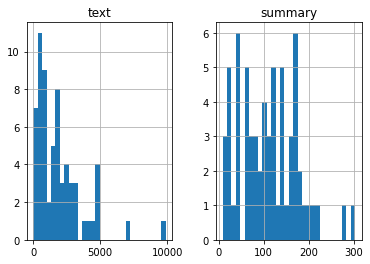

In [14]:
text_overall, summary_overall  = [], []
text_count, summary_count = [], []

directory = '../../data'
for filename in os.listdir(directory):
    with open('../../data/'+filename) as f:
        lines = f.readlines()
        f.close()

        summary, lines = split_data(lines)
        summary, lines = split_summary(summary), split_string(lines)

        clean_text = []
        tex_count = 0
        for line in lines:
            temp = clean(line)
            if temp != []:
                tex_count += (len(temp))
                for t in temp:
                    clean_text.append(t)  
        text_overall.append(clean_text)
        text_count.append(tex_count)

        clean_summary = []
        sum_count = 0
        for line in summary:
            temp = clean(line)
            if temp != []:
                sum_count+= (len(temp))
                for t in temp:
                    clean_summary.append(t)
        summary_overall.append(clean_summary)
        summary_count.append(sum_count)
        
print(summary_count[:10])
print(text_count[:10])
print(np.array(text_overall).shape, len(summary_overall))
overview = pd.DataFrame({'text':text_count, 'summary':summary_count})
overview.hist(bins=30)
plt.show()

## Store sentence vectors:
We store a matrix of sentence vectors where each sentence is a vector and within each index stores the and index in the dictionary corresponding to the word.
The end of the sequences are padded with 0's.

In [15]:
max_text_len = 5000
max_summary_len = 200
x_train, x_test, y_train, y_test = train_test_split(text_overall, summary_overall, test_size=0.1, shuffle=True)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=max_text_len, padding='post', truncating='post')
x_test = pad_sequences(x_train, maxlen=max_text_len, padding='post', truncating='post')

print(x_train[:10])
x_voc_size = len(tokenizer.word_index)+1
print(x_voc_size)

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_train)

y_train = y_tokenizer.texts_to_sequences(y_train)
y_test = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train, maxlen=max_summary_len, padding='post', truncating='post')
y_test = pad_sequences(y_train, maxlen=max_summary_len, padding='post', truncating='post')

print(y_train[:10])
y_voc_size = len(tokenizer.word_index)+1
print(y_voc_size)

[[ 378  189    8 ...    0    0    0]
 [ 605   28  605 ...    0    0    0]
 [2412  769 1646 ...    0    0    0]
 ...
 [  80 3481   30 ...    0    0    0]
 [  80  361    8 ...    0    0    0]
 [1972 1969  175 ...    0    0    0]]
15472
[[  1   1  42 ... 361  25 252]
 [  1   1  12 ...   0   0   0]
 [  1   1 268 ...   0   0   0]
 ...
 [  1   1   6 ...   0   0   0]
 [  1   1  76 ...   0   0   0]
 [  1   1 217 ...   0   0   0]]
15472


## Save the preprocessed data to file

In [16]:
np.savez('preprocessed', x_train=x_train, x_test=x_test, y_train=y_train,y_test=y_test, 
                             max_text_len=max_text_len, max_summary_len=max_summary_len, x_voc_size=x_voc_size, y_voc_size=y_voc_size)